# Fine-tuned Models Post-processing

* Minimal: Decode model outputs back to text and semantic tags (merge B/I, skip O)
* Good to have: Extract word-tag pairs
* Best to have: Map words to SNOMED CT terms

In [1]:
# Utils
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# torch essentials
import torch
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

from transformers import Trainer, TrainingArguments
from seqeval.metrics import classification_report
from transformers import EvalPrediction
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Self-defined utils
import sys
sys.path.append(os.path.abspath("../utils"))
from bert_dataset import BERTDataset
from deberta_dataset import DeBERTaDataset
from prepare_dataset import prepare_data

## BERT (Finetuned)

Training Arguments
```
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    learning_rate=2e-5, # smaller learning rate
    seed=42, # for deterministic results
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=500,
    fp16=True, # mixed precision training
    report_to="none",
)
```

Performance:
|               | Accuracy | Precision | Recall | F1     | Validation Loss | Train Runtime |
|---------------|----------|-----------|--------|--------|-----------------|---------------|
| BERT          | 0.9288   | 0.7144    | 0.7751 | 0.7435 | 0.2834          | 1239.1881     |

In [3]:
# Global variables
MAX_LEN = 128
DATA_PATH = "../processed_notes.csv"

In [4]:
# Step 0: Load Fine-tuned model and Tokenier
model_path = "../saved_bert_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(
    model_path,
    low_cpu_mem_usage=True,
    device_map="auto")

In [5]:
# Step 1: Load Dataset
data_dict = prepare_data("../processed_notes.csv")
data = data_dict["data"]
labels_to_ids = data_dict["labels_to_ids"]
ids_to_labels = data_dict["ids_to_labels"]

NUM_LABELS = len(labels_to_ids)
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# we only evaluate on the testing set here
testing_set = BERTDataset(test_dataset, tokenizer, MAX_LEN, labels_to_ids)

FULL Dataset: (20305, 4)
TRAIN Dataset: (16244, 4)
TEST Dataset: (4061, 4)


In [11]:
def compute_metrics(p: EvalPrediction):
    predictions = p.predictions
    labels = p.label_ids

    # Get the class with highest probability for each token
    predicted_ids = np.argmax(predictions, axis=-1)

    true_labels = []
    true_predictions = []

    for pred, label in zip(predicted_ids, labels):
        curr_preds = []
        curr_labels = []
        for p_id, l_id in zip(pred, label):
            if l_id != -100:
                curr_preds.append(ids_to_labels[p_id])  # predicted label string
                curr_labels.append(ids_to_labels[l_id])  # true label string
        true_predictions.append(curr_preds)
        true_labels.append(curr_labels)
    print(classification_report(true_labels, true_predictions))
    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions)
    }


In [12]:
# Step 2: Evaluation on the validation set
args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    do_eval=True,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

metrics = trainer.evaluate(testing_set)
print(metrics)

/var/folders/ch/1v21vldj0m1dk5lxd7kjbrh80000gn/T/ipykernel_17334/40364536.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


              precision    recall  f1-score   support

        ACTI       0.67      0.59      0.62        17
        ANAT       0.63      0.72      0.67       755
        CHEM       1.00      0.75      0.86         4
        CONC       0.54      0.56      0.55        66
        DISO       0.76      0.82      0.79      5023
        OBJC       0.67      0.50      0.57         4
        PHEN       0.50      0.04      0.08        23
        PHYS       0.83      0.73      0.77        85
        PROC       0.63      0.71      0.67      1938
         UNK       0.35      0.30      0.32        27

   micro avg       0.71      0.78      0.74      7942
   macro avg       0.66      0.57      0.59      7942
weighted avg       0.72      0.78      0.74      7942

{'eval_loss': 0.28257325291633606, 'eval_model_preparation_time': 0.0016, 'eval_accuracy': 0.9288112929449485, 'eval_precision': 0.7143354210160056, 'eval_recall': 0.7754973558297658, 'eval_f1': 0.7436609514609998, 'eval_runtime': 30.649, 'e

In [20]:
# Inject into model config
model.config.id2label = {i: ids_to_labels[i] for i in ids_to_labels}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}

In [21]:
# Step 3: Decoding Pipeline
ner_pipe = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple",  # combines B/I tokens into full spans
)

Device set to use mps


In [27]:
predictions = ner_pipe('''
    No urgent indications of dialysis including uremia, persistent severe hyperkalemia, refractory metabolic acidosis.  However patient is extremely hypervolemic 

    Triggers are likely diarrhea and recent starting of colchicine for gout.   

    Hold off on diuretics  

    Monitor creatinine closely  

    Patient is willing for hemodialysis.  We will put Eliquis on hold, plan for PermCath and nephrology consultation  
    ''')
# Print nicely aligned output
print(f"{'Entity':<30} {'Tag':<10} {'Score':<6}")
print("-" * 50)

for ent in predictions:
    if ent["entity_group"] != "O":  # Optional: filter out "O"
        print(f"{ent['word']:<30} {ent['entity_group']:<10} {ent['score']:.2f}")

Entity                         Tag        Score 
--------------------------------------------------
dialysis                       PROC       0.95
ur                             DISO       1.00
##emia                         DISO       0.86
severe                         DISO       0.95
hyperkalemia                   DISO       0.99
refrac                         DISO       0.99
##tory metabolic acidosis      DISO       0.99
dia                            DISO       1.00
##rr                           DISO       1.00
##hea                          DISO       0.65
gout                           DISO       0.89
diuretics                      PROC       0.85
monitor creatinine             PROC       0.86
hemodialysis                   PROC       0.96
consultation                   PROC       0.69


In [28]:
predictions = ner_pipe('''
        Patient reported that he has been having diarrhea which she described as liquid stools with incontinence.  
        He also reported burning in the urine.  
        He has been taking all of his medications including Bumex, colchicine 
        ''')
# Print nicely aligned output
print(f"{'Entity':<30} {'Tag':<10} {'Score':<6}")
print("-" * 50)

for ent in predictions:
    if ent["entity_group"] != "O":  # Optional: filter out "O"
        print(f"{ent['word']:<30} {ent['entity_group']:<10} {ent['score']:.2f}")

Entity                         Tag        Score 
--------------------------------------------------
dia                            DISO       1.00
##rrhea                        DISO       1.00
liquid stools                  DISO       0.98
incontinence                   DISO       0.98
burning in the urine           DISO       1.00
medications                    PROC       0.57


## Clinical BERT (Finetuned)

In [29]:
# Step 0: Load Fine-tuned model and Tokenier
model_path = "../saved_clinicalbert_model_epoch6"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(
    model_path,
    low_cpu_mem_usage=True,
    device_map="auto")

In [31]:
# dataset is the same as BERT
testing_set = BERTDataset(test_dataset, tokenizer, MAX_LEN, labels_to_ids)

In [32]:
# Step 2: Evaluation on the validation set
args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    do_eval=True,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

metrics = trainer.evaluate(testing_set)
print(metrics)

/var/folders/ch/1v21vldj0m1dk5lxd7kjbrh80000gn/T/ipykernel_17334/40364536.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


              precision    recall  f1-score   support

        ACTI       0.69      0.53      0.60        17
        ANAT       0.64      0.71      0.67       750
        CHEM       1.00      0.75      0.86         4
        CONC       0.59      0.58      0.58        64
        DISO       0.76      0.82      0.79      4965
        OBJC       0.67      0.50      0.57         4
        PHEN       0.09      0.04      0.06        23
        PHYS       0.80      0.71      0.75        84
        PROC       0.66      0.72      0.69      1917
         UNK       0.50      0.19      0.27        27

   micro avg       0.72      0.78      0.75      7855
   macro avg       0.64      0.55      0.58      7855
weighted avg       0.72      0.78      0.75      7855

{'eval_loss': 0.25763267278671265, 'eval_model_preparation_time': 0.0007, 'eval_accuracy': 0.930499335543098, 'eval_precision': 0.7231718898385565, 'eval_recall': 0.7755569700827498, 'eval_f1': 0.7484489219239511, 'eval_runtime': 18.3468, 'e

## Bio-Clinical-BERT Finetuned

In [33]:
# Step 0: Load Fine-tuned model and Tokenier
model_path = "../saved_model_bioclinical"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(
    model_path,
    low_cpu_mem_usage=True,
    device_map="auto")

In [34]:
# dataset is the same as BERT
testing_set = BERTDataset(test_dataset, tokenizer, MAX_LEN, labels_to_ids)

In [35]:
# Step 2: Evaluation on the validation set
args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    do_eval=True,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

metrics = trainer.evaluate(testing_set)
print(metrics)

/var/folders/ch/1v21vldj0m1dk5lxd7kjbrh80000gn/T/ipykernel_17334/40364536.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


              precision    recall  f1-score   support

        ACTI       0.67      0.59      0.62        17
        ANAT       0.67      0.72      0.69       752
        CHEM       1.00      1.00      1.00         4
        CONC       0.54      0.57      0.55        65
        DISO       0.76      0.83      0.79      4973
        OBJC       0.75      0.75      0.75         4
        PHEN       0.08      0.04      0.06        23
        PHYS       0.77      0.74      0.75        84
        PROC       0.66      0.73      0.69      1919
         UNK       0.57      0.30      0.39        27

   micro avg       0.72      0.79      0.76      7868
   macro avg       0.65      0.63      0.63      7868
weighted avg       0.72      0.79      0.75      7868

{'eval_loss': 0.2790846526622772, 'eval_model_preparation_time': 0.0014, 'eval_accuracy': 0.9315060121312126, 'eval_precision': 0.7239328201539538, 'eval_recall': 0.7888917132689375, 'eval_f1': 0.7550176377569638, 'eval_runtime': 34.96, 'eva

## Evaluation Plots

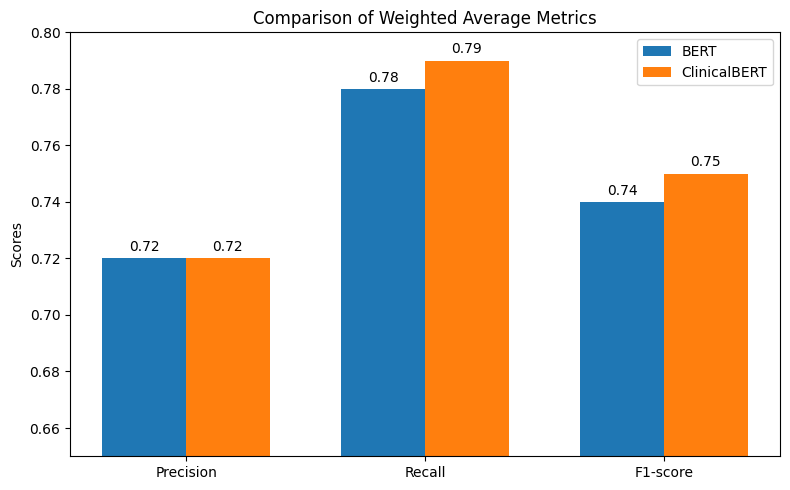

In [38]:
# Define the weighted average metrics for each model
metrics = ['Precision', 'Recall', 'F1-score']
bert_weighted = [0.72, 0.78, 0.74]
clinicalbert_weighted = [0.72, 0.79, 0.75]

# Setup the x-axis positions for each metric
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, bert_weighted, width, label='BERT')
rects2 = ax.bar(x + width/2, clinicalbert_weighted, width, label='ClinicalBERT')

# Add labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of Weighted Average Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add numeric labels on top of the bars for clarity
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # offset in points
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0.65, 0.80)
plt.tight_layout()
plt.show()
